In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# Later, for ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklearn below, this keeps them 
# out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales_train = pd.read_csv('../data/sales_train_validation.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')
calendar = pd.read_csv('../data/calendar.csv')

In [177]:
sales_train

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  \
0         CA_1       CA    0    0    0    0  ...       1       3       0   
1         CA_1       CA    0    0    0    0  ...       0       0       0   
2         CA_1       CA    0    0    0    0  ...       2       1       2   
3         CA_1       CA    0    0    0    0  ...       1       0       5   
4         CA_1       CA    0    0    0    0  ...       2       1       1   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       2       0       0   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       2       1       0   
30488     WI_3       WI    0    0    0    0  ...       0       0       1   
30489     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
0           1       1       1       3       0       1       1  
1           0       0       1       0       0       0       0  
2           1       1       1       0       1       1       1  
3           4       1       0       1       3       7       2  
4           0       1       1       2       2       2       4  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       0       0       1       0       0       1  
30486       0       0       0       0       0       1       0  
30487       2       0       1       0       0       1       0  
30488       0       0       1       0       3       1       3  
30489       0       0       0       0       0       0       0  

[30490 rows x 1919 columns]

In [181]:
sales_train_store = sales_train.groupby(['store_id']).sum()
sales_train_store

d_1   d_2   d_3   d_4   d_5   d_6   d_7   d_8   d_9  d_10  ...  \
store_id                                                              ...   
CA_1      4337  4155  2816  3051  2630  3276  3450  5437  4340  3157  ...   
CA_2      3494  3046  2121  2324  1942  2288  2629  3729  2957  2218  ...   
CA_3      4739  4827  3785  4232  3817  4369  4703  5456  5581  4912  ...   
CA_4      1625  1777  1386  1440  1536  1389  1469  1988  1818  1535  ...   
TX_1      2556  2687  1822  2258  1694  2734  1691  2820  2887  2174  ...   
TX_2      3852  3937  2731  2954  2492  3439  2588  3772  3657  2932  ...   
TX_3      3030  3006  2225  2169  1726  2833  1947  2848  2832  2213  ...   
WI_1      2704  2194  1562  1251     2  2049  2815  3248  1674  1355  ...   
WI_2      2256  1922  2018  2522  1175  2244  2232  2643  2140  1836  ...   
WI_3      4038  4198  3317  3211  2132  4590  4486  5991  4850  3240  ...   

          d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  d_1911  \
store_id                                                                   
CA_1        3982    5437    5954    4345    3793    3722    3709    4387   
CA_2        4440    5352    5760    3830    3631    3691    3303    4457   
CA_3        5337    6936    8271    6068    5683    5235    5018    5623   
CA_4        2496    2839    3047    2809    2677    2500    2458    2628   
TX_1        3084    3724    4192    3410    3257    2901    2776    3022   
TX_2        3897    4475    4998    3311    3727    3384    3446    3902   
TX_3        3819    4261    4519    3147    3938    3315    3380    3691   
WI_1        3862    4862    4812    3236    3069    3242    3324    3991   
WI_2        6259    5579    5566    4347    4464    4194    4393    4988   
WI_3        4613    4897    4521    3556    3331    3159    3226    3828   

          d_1912  d_1913  
store_id                  
CA_1        5577    6113  
CA_2        5884    6082  
CA_3        7419    7721  
CA_4        2954    3271  
TX_1        3700    4033  
TX_2        4483    4292  
TX_3        4083    3957  
WI_1        4772    4874  
WI_2        5404    5127  
WI_3        4686    4325  

[10 rows x 1913 columns]

In [94]:
def update_calendar(cutoff):
    calendar_update = calendar.iloc[:cutoff, :]
    calendar_dates = calendar_update[['date', 'd']]
    calendar_dates = calendar_dates.set_index('d')
    return calendar_dates

calendar_updates = update_calendar(1913)

In [182]:
sales_train_cat = sales_train.groupby(['cat_id']).sum()
sales_train_cat_food = sales_train_cat.iloc[0, :].T
sales_train_cat_hobbies = sales_train_cat.iloc[1, :].T
sales_train_cat_household = sales_train_cat.iloc[2, :].T

sales_train_cat.loc['TOTAL']= sales_train_cat.sum()
sales_train_cat_all = sales_train_cat.iloc[3, :].T

sales_train_dept = sales_train.groupby(['dept_id']).sum()
sales_train_dept_food1 = sales_train_dept.iloc[0, :].T
sales_train_dept_food2 = sales_train_dept.iloc[1, :].T
sales_train_dept_food3 = sales_train_dept.iloc[2, :].T
sales_train_dept_hobbies1 = sales_train_dept.iloc[3, :].T
sales_train_dept_hobbies2 = sales_train_dept.iloc[4, :].T
sales_train_dept_household1 = sales_train_dept.iloc[5, :].T
sales_train_dept_household2 = sales_train_dept.iloc[6, :].T

sales_train_state = sales_train.groupby(['state_id']).sum()
sales_train_ca = sales_train_state.iloc[0, :].T
sales_train_tx = sales_train_state.iloc[1, :].T
sales_train_wi = sales_train_state.iloc[2, :].T

sales_train_store = sales_train.groupby(['store_id']).sum()
sales_train_ca1 = sales_train_store.iloc[0, :].T
sales_train_ca2 = sales_train_store.iloc[1, :].T
sales_train_ca3 = sales_train_store.iloc[2, :].T
sales_train_ca4 = sales_train_store.iloc[3, :].T
sales_train_tx1 = sales_train_store.iloc[4, :].T
sales_train_tx2 = sales_train_store.iloc[5, :].T
sales_train_tx3 = sales_train_store.iloc[6, :].T
sales_train_wi1 = sales_train_store.iloc[7, :].T
sales_train_wi2 = sales_train_store.iloc[8, :].T
sales_train_wi3 = sales_train_store.iloc[9, :].T

In [183]:
def drop_christmas(series):
    df = calendar[['date', 'd']]
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['month'] = df.index.month
    df['day'] = df.index.day
    month_mask = df['month'] == 12
    day_mask = df['day'] == 25
    df = df[month_mask & day_mask]
    df = df.drop(columns = ['month', 'day'])
    df['date'] = df.index
    df = df.set_index('d')
    lst = df.index.tolist()
    return series.drop(index = lst)

sales_train_cat_food = drop_christmas(sales_train_cat_food)
sales_train_cat_hobbies = drop_christmas(sales_train_cat_hobbies)
sales_train_cat_household = drop_christmas(sales_train_cat_household)

sales_train_cat_all = drop_christmas(sales_train_cat_all)

sales_train_dept_food1 = drop_christmas(sales_train_dept_food1)
sales_train_dept_food2 = drop_christmas(sales_train_dept_food2)
sales_train_dept_food3 = drop_christmas(sales_train_dept_food3)
sales_train_dept_hobbies1 = drop_christmas(sales_train_dept_hobbies1)
sales_train_dept_hobbies2 = drop_christmas(sales_train_dept_hobbies2)
sales_train_dept_household1 = drop_christmas(sales_train_dept_household1)
sales_train_dept_household2 = drop_christmas(sales_train_dept_household2)

sales_train_ca = drop_christmas(sales_train_ca)
sales_train_tx = drop_christmas(sales_train_tx)
sales_train_wi = drop_christmas(sales_train_wi)

sales_train_ca1 = drop_christmas(sales_train_ca1)
sales_train_ca2 = drop_christmas(sales_train_ca2)
sales_train_ca3 = drop_christmas(sales_train_ca3)
sales_train_ca4 = drop_christmas(sales_train_ca4)
sales_train_tx1 = drop_christmas(sales_train_tx1)
sales_train_tx2 = drop_christmas(sales_train_tx2)
sales_train_tx3 = drop_christmas(sales_train_tx3)
sales_train_wi1 = drop_christmas(sales_train_wi1)
sales_train_wi2 = drop_christmas(sales_train_wi2)
sales_train_wi3 = drop_christmas(sales_train_wi3)

In [221]:
def make_date_time(Series):
    df = pd.DataFrame(Series)
    df1 = df.join(calendar_dates)
    df1['date'] = pd.to_datetime(df1['date'])
    df1 = df1.set_index('date')
    return df1

big_food = make_date_time(sales_train_cat_food)
big_hobby = make_date_time(sales_train_cat_hobbies)
big_household = make_date_time(sales_train_cat_household)

big_all = make_date_time(sales_train_cat_all)

med_food1 = make_date_time(sales_train_dept_food1)
med_food2 = make_date_time(sales_train_dept_food2)
med_food3 = make_date_time(sales_train_dept_food3)
med_hobby1 = make_date_time(sales_train_dept_hobbies1)
med_hobby2 = make_date_time(sales_train_dept_hobbies2)
med_household1 = make_date_time(sales_train_dept_household1)
med_household2 = make_date_time(sales_train_dept_household2)

state_ca = make_date_time(sales_train_ca)
state_tx = make_date_time(sales_train_tx)
state_wi = make_date_time(sales_train_wi)

store_ca1 = make_date_time(sales_train_ca1)
store_ca2 = make_date_time(sales_train_ca2)
store_ca3 = make_date_time(sales_train_ca3)
store_ca4 = make_date_time(sales_train_ca4)
store_tx1 = make_date_time(sales_train_tx1)
store_tx2 = make_date_time(sales_train_tx2)
store_tx3 = make_date_time(sales_train_tx3)
store_wi1 = make_date_time(sales_train_wi1)
store_wi2 = make_date_time(sales_train_wi2)
store_wi3 = make_date_time(sales_train_wi3)

series_lst = [big_all, big_food, big_hobby, big_household,
              med_food1, med_food2, med_food3, med_hobby1, med_hobby2, med_household1, med_household2,
              state_ca, state_tx, state_wi,
              store_ca1, store_ca2, store_ca3, store_ca4, store_tx1, store_tx2, store_tx3, store_wi1, store_wi2, store_wi3
             ]

In [98]:
#To make a graph with a linear trendline
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(name)
    
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)    
    
# To make a detrended graph
def detrended_graph(Series):
    python_series = Series
    python_linear_trend = fit_linear_trend(python_series)
    python_series_detrended = python_series - python_linear_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(python_series_detrended.index, python_series_detrended)
    ax.set_title("Walmart Total Food Sales Detrended")
    plt.tight_layout()
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

In [99]:
def create_monthly_dummies(series):
    i = series.index.interval
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(i).iloc[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series, interval='month'):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)
    
#fig, ax = plt.subplots(figsize=(14, 5))
#plot_seasonal_trend(ax, 'hobbies', df1)
#plt.tight_layout()

In [100]:
def deseasonalize(Series):
    series = Series.iloc[:, 0]
    seasonal_trend = fit_seasonal_trend(Series)
    easonal_detrended = series - seasonal_trend

    fig, ax = plt.subplots(1, figsize=(14, 2))
    ax.plot(Series.index, _seasonal_detrended)
    ax.set_title(f'Walmart {list(Series)[0]} Sales, Deseasonalized')

In [101]:
def resample_series(series, interval):
    df = series.resample(interval).sum()
    df = df.iloc[1:, :]
    df = df.iloc[:-1, :]
    return df

In [102]:
def plot_seasonal_decomposition(axs, series):
    sd = sm.tsa.seasonal_decompose(series)
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

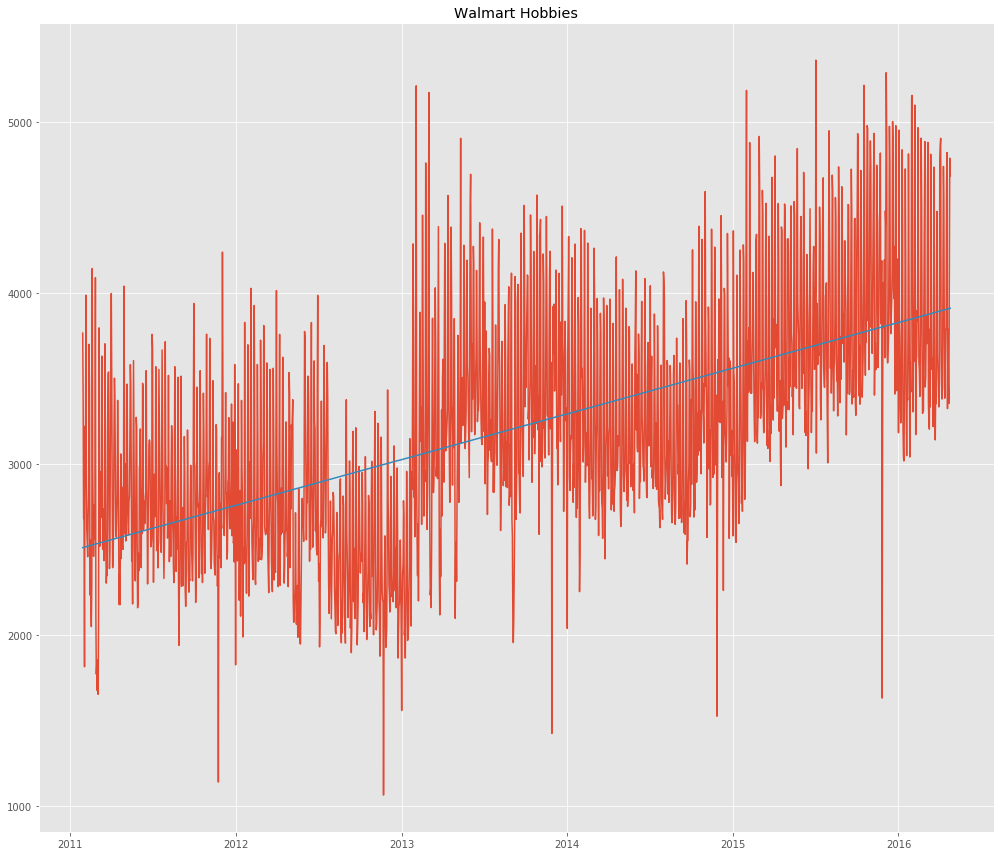

In [106]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart Hobbies', big_hobby)
plt.tight_layout()

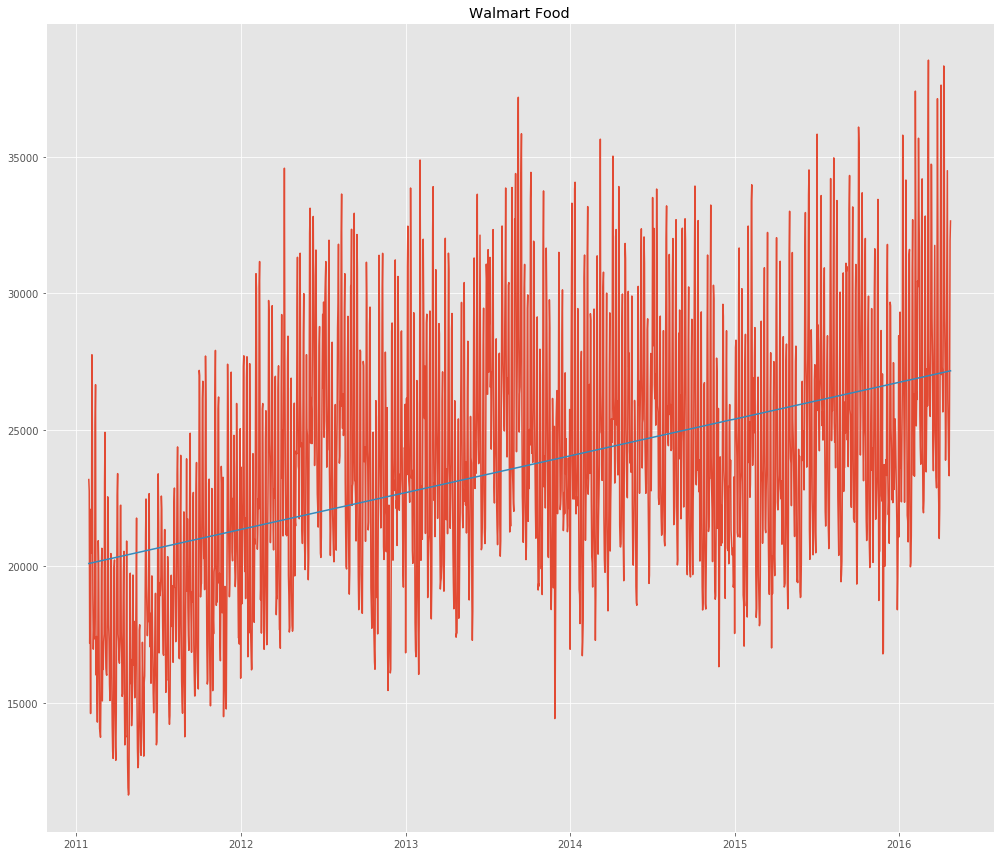

In [107]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart Food', big_food)
plt.tight_layout()

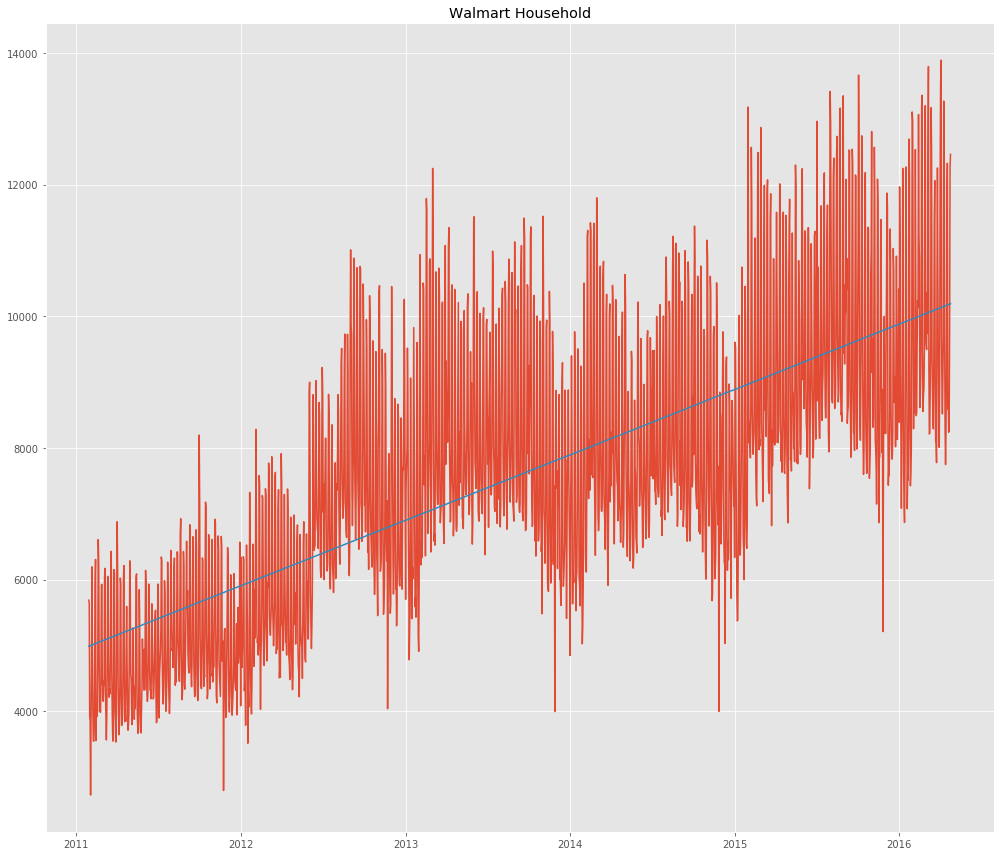

In [108]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart Household', big_household)
plt.tight_layout()

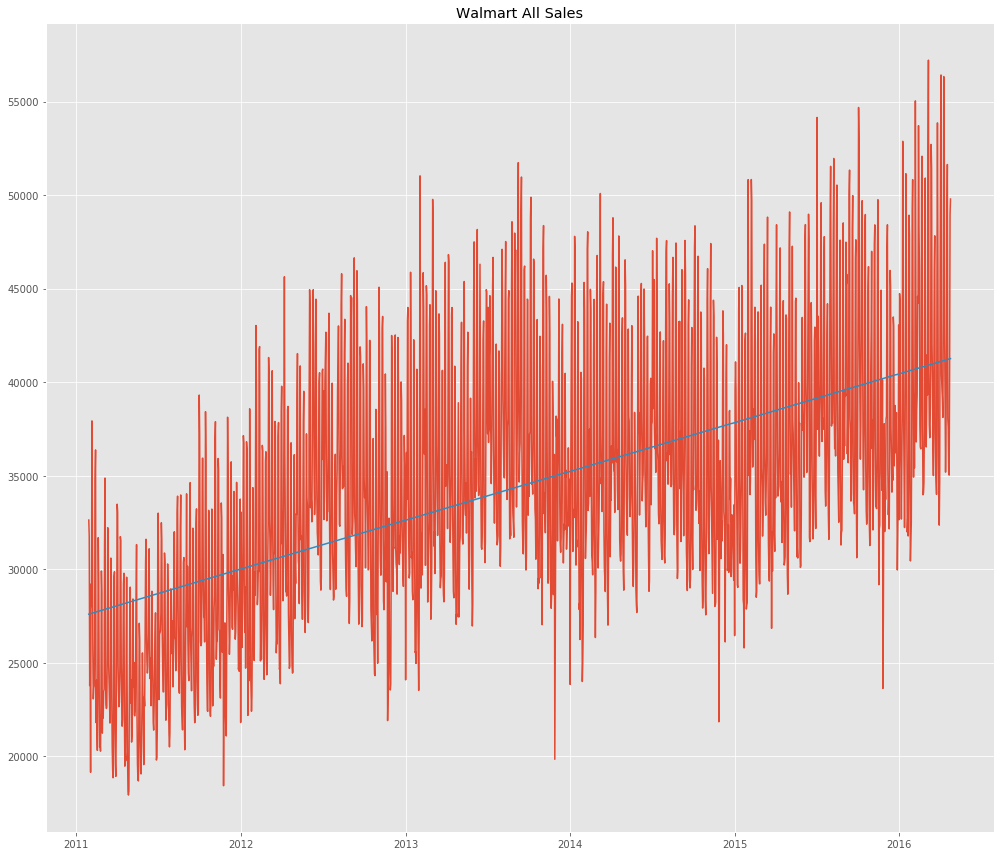

In [133]:
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, 'Walmart All Sales', big_all)
plt.tight_layout()

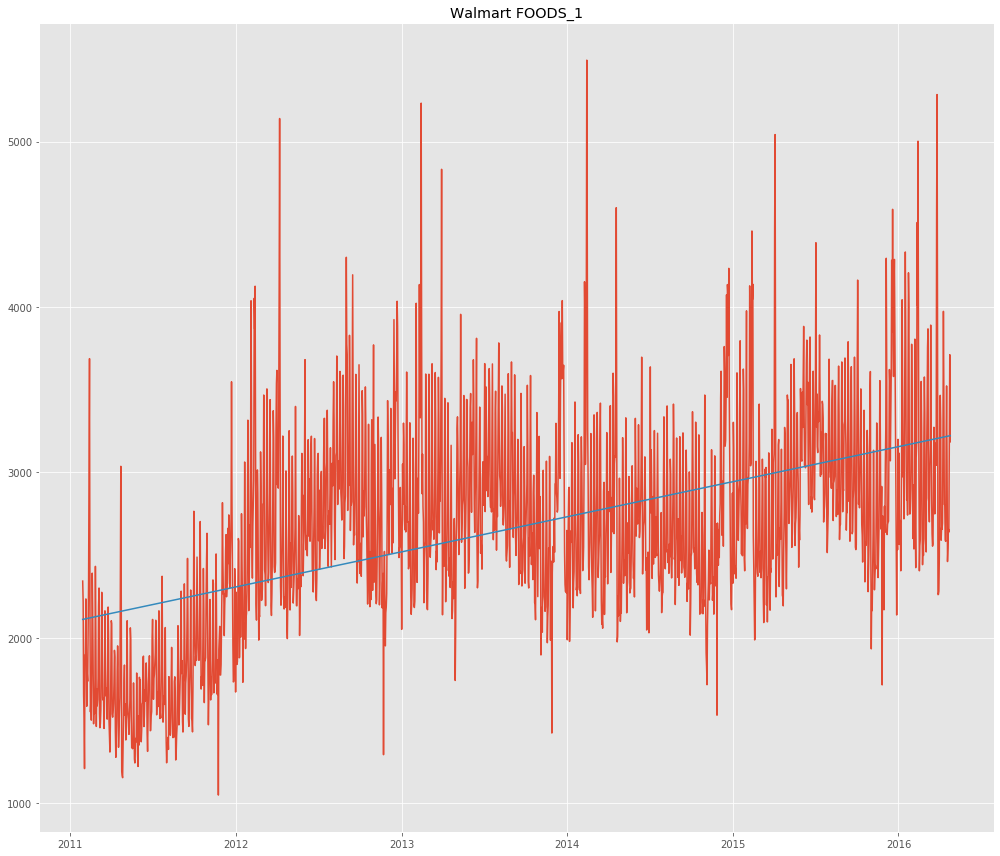

In [154]:
series = med_food1
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

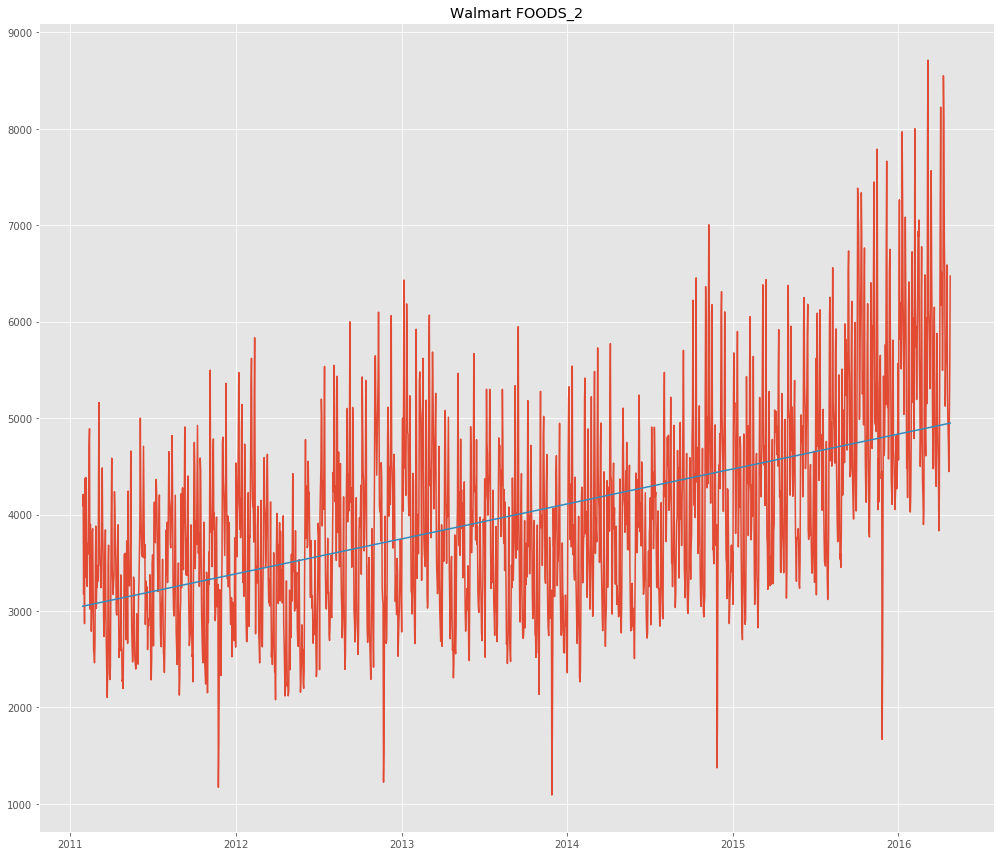

In [153]:
series = med_food2
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

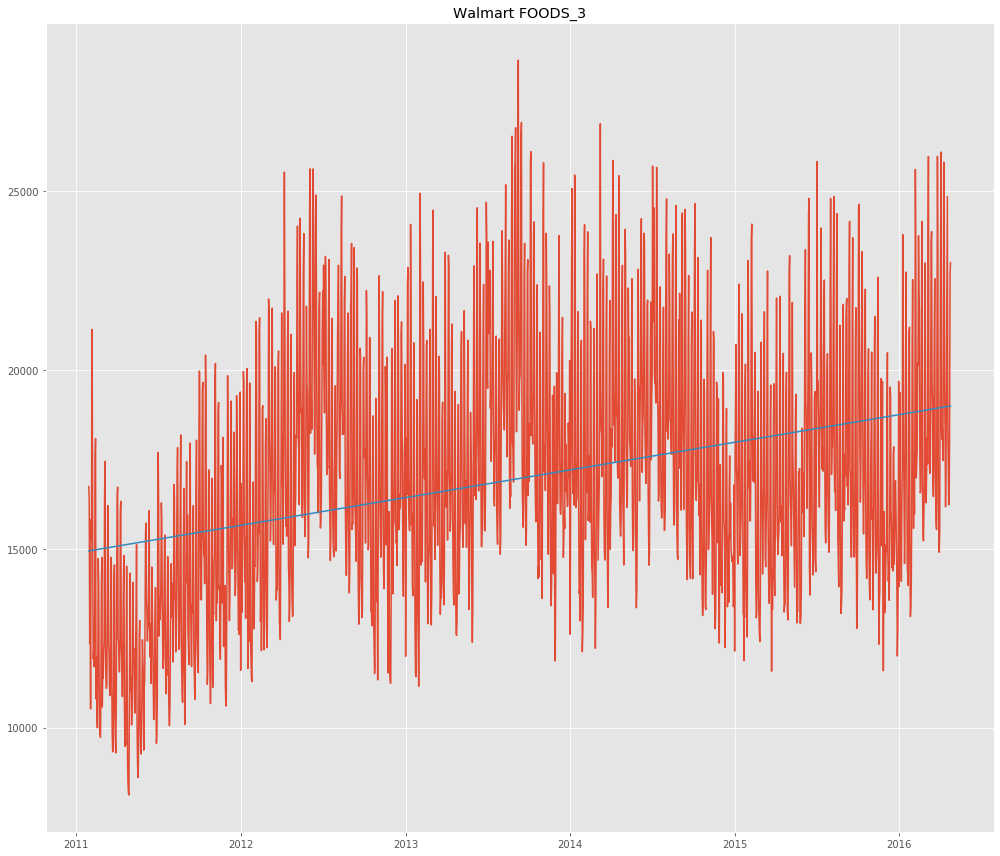

In [155]:
series = med_food3
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

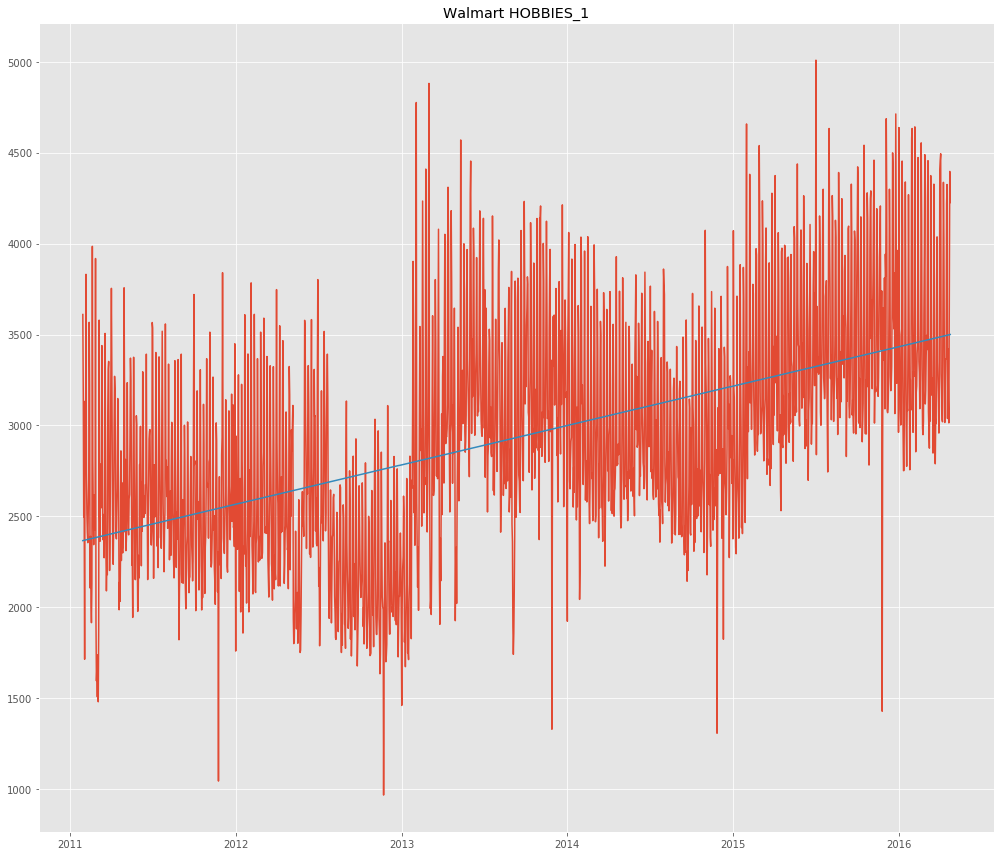

In [156]:
series = med_hobby1
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

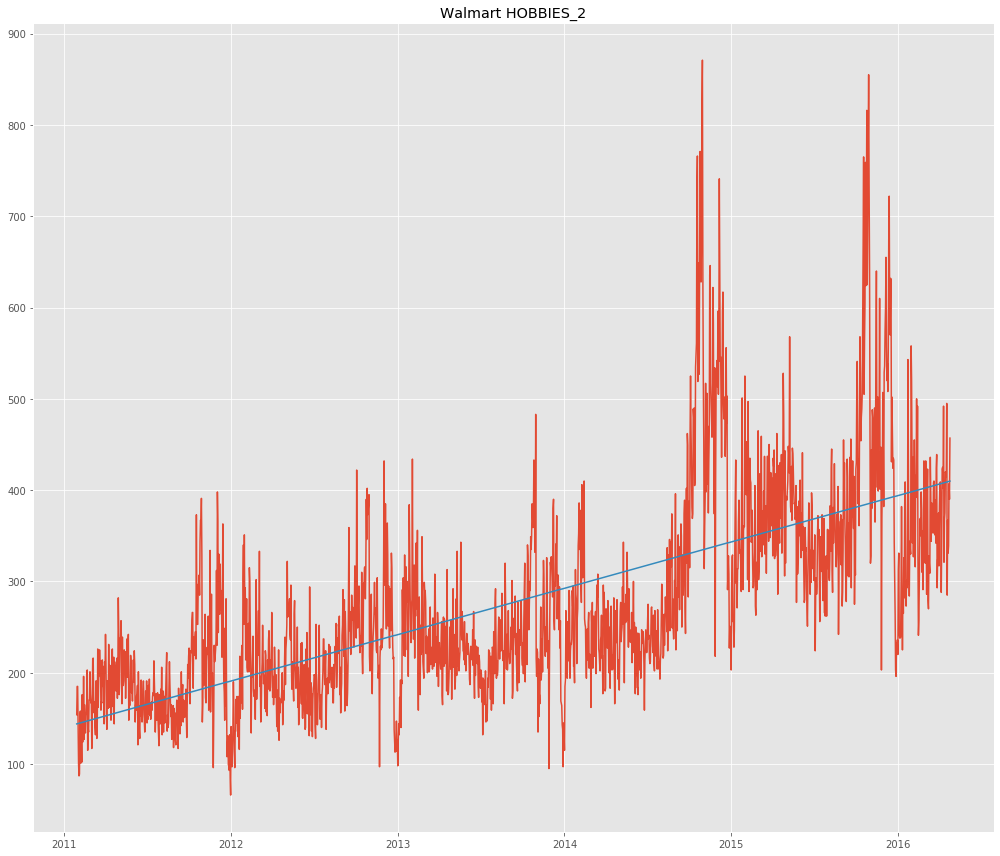

In [157]:
series = med_hobby2
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

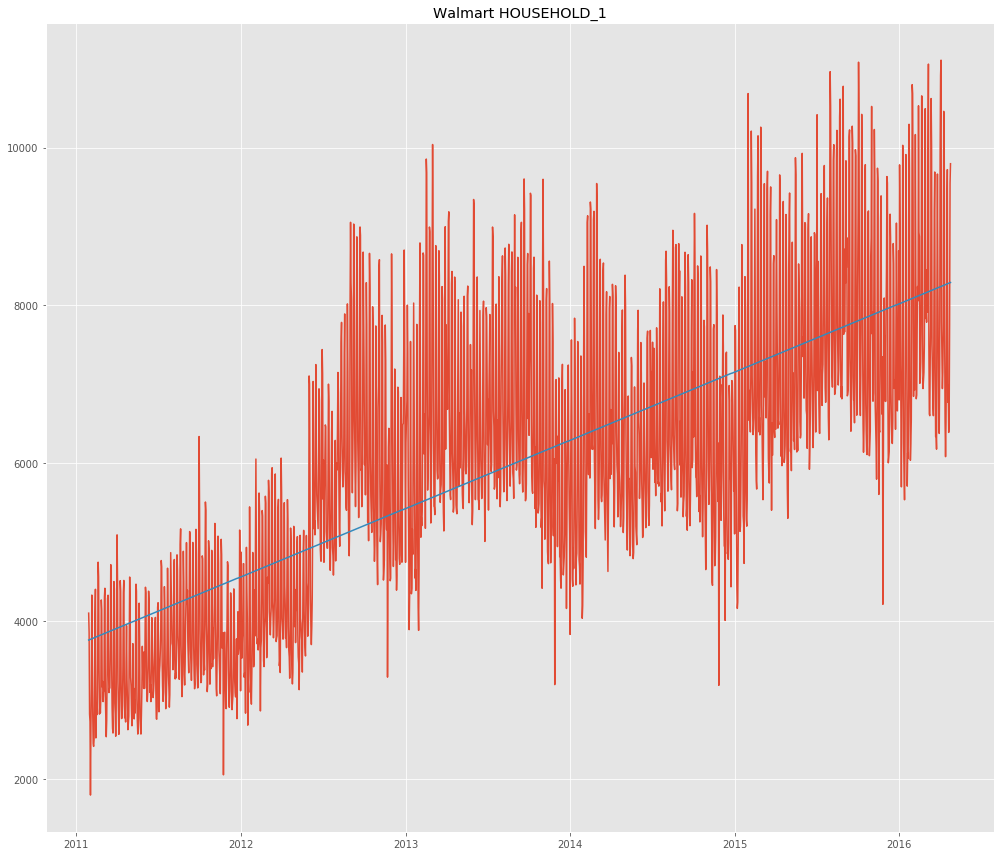

In [158]:
series = med_household1
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

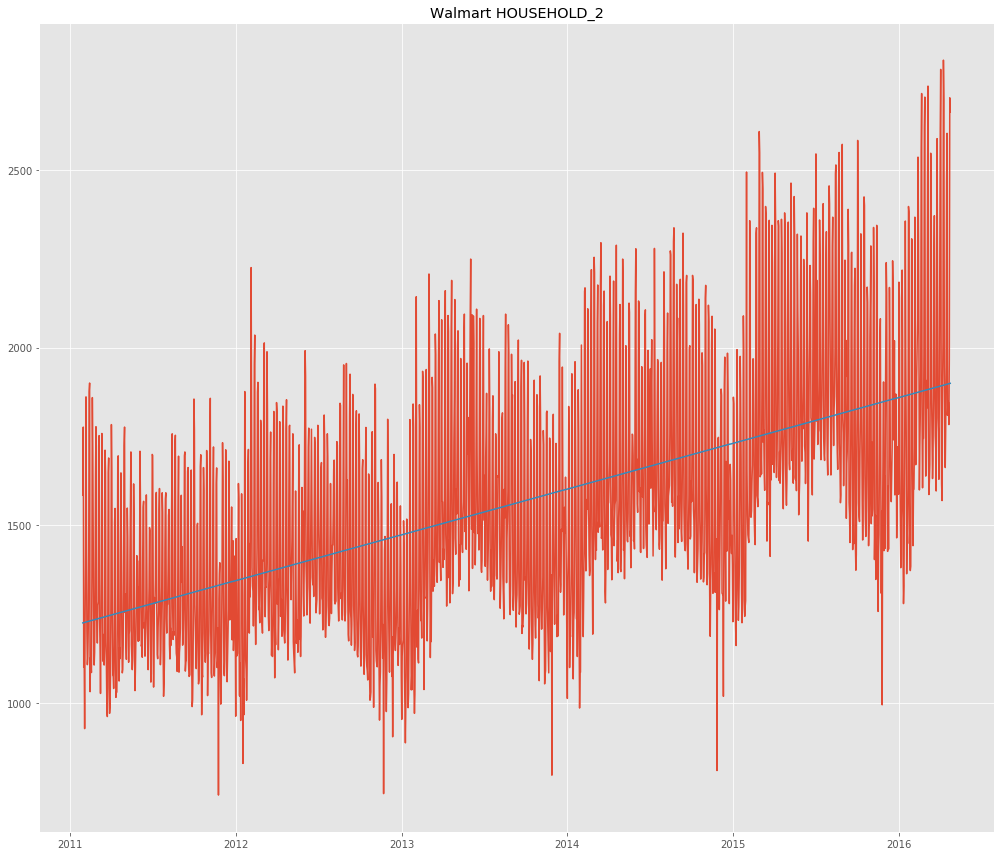

In [159]:
series = med_household2
fig, ax = plt.subplots(1, figsize=(14, 12))
plot_linear_trend(ax, f'Walmart {list(series)[0]}', series)
plt.tight_layout()

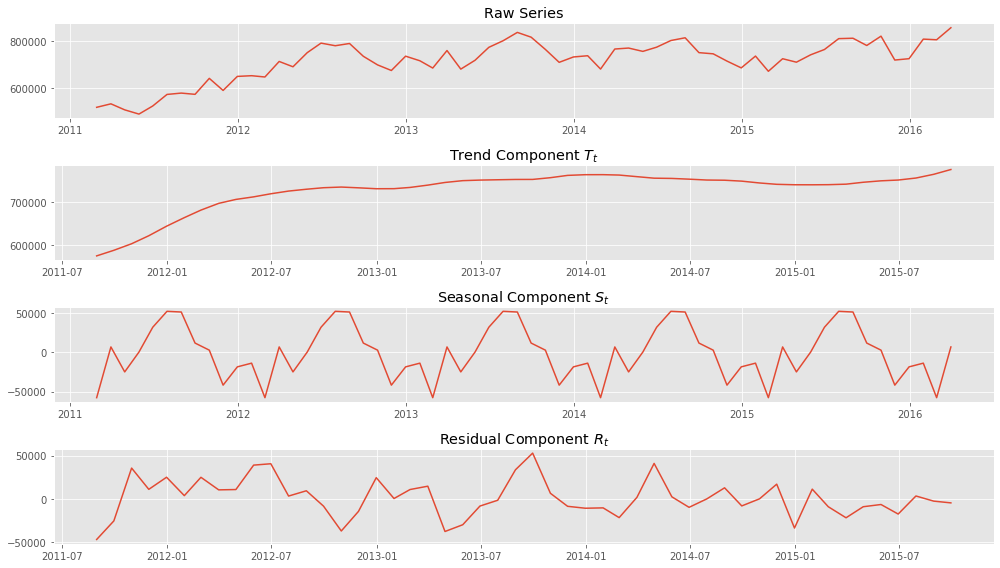

In [289]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_food, 'M'))
plt.tight_layout()

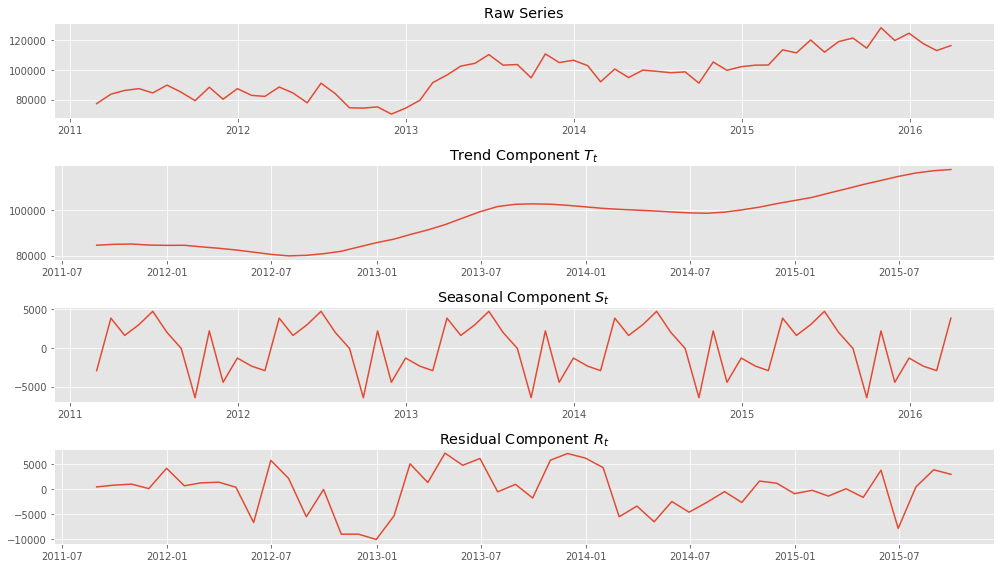

In [290]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_hobby, 'M'))
plt.tight_layout()

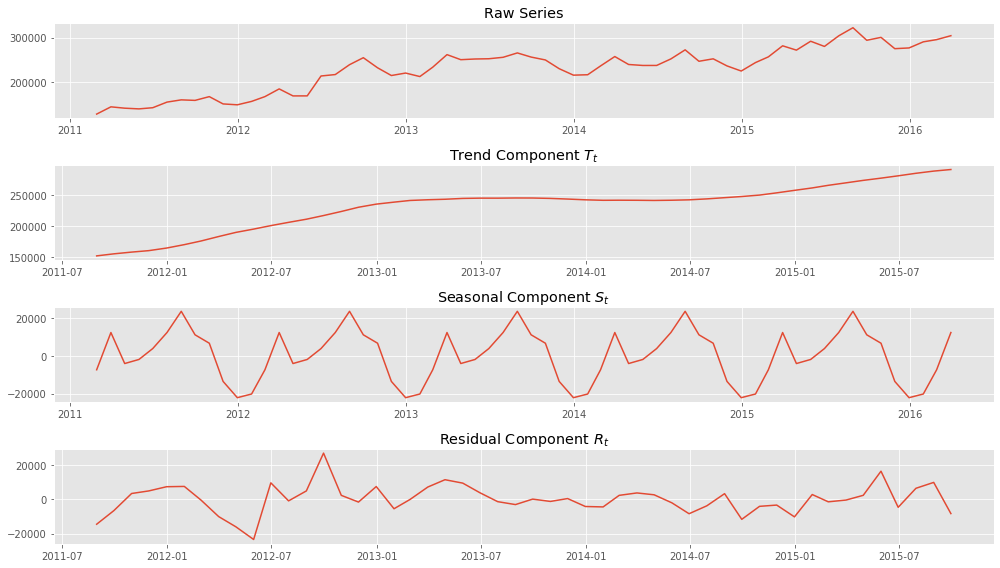

In [291]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_household, 'M'))
plt.tight_layout()

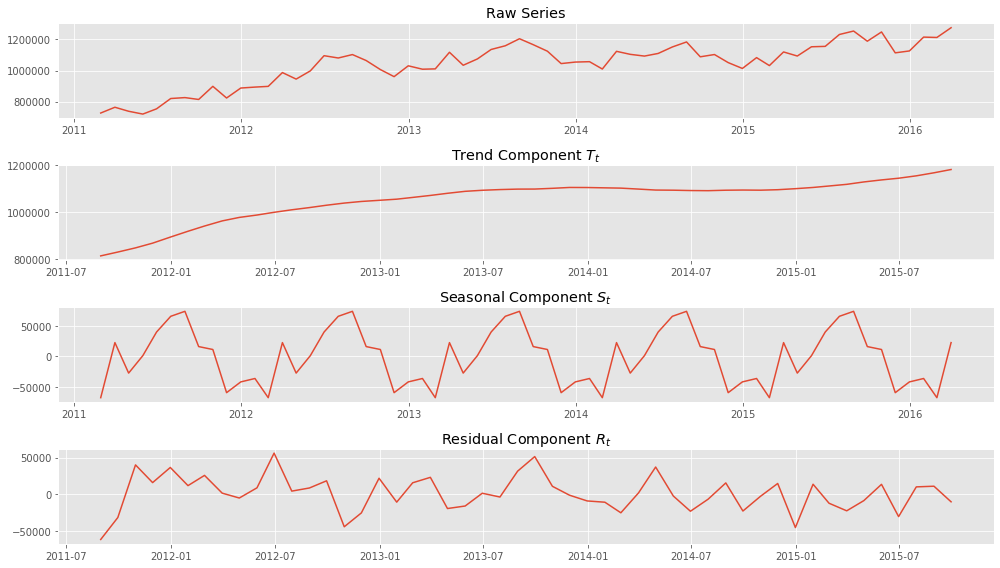

In [296]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(big_all, 'M'))
plt.tight_layout()

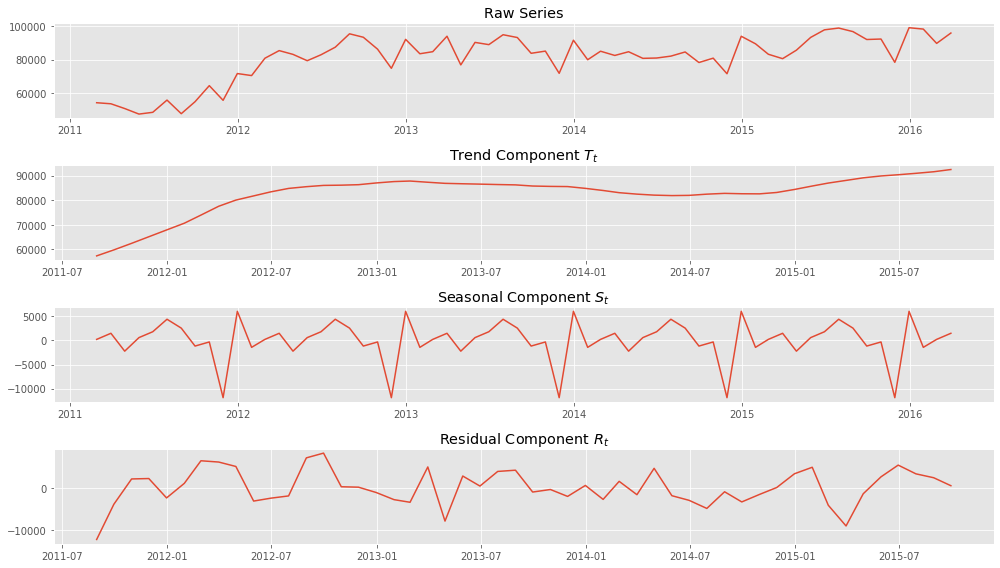

In [166]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_food1, 'M'))
plt.tight_layout()

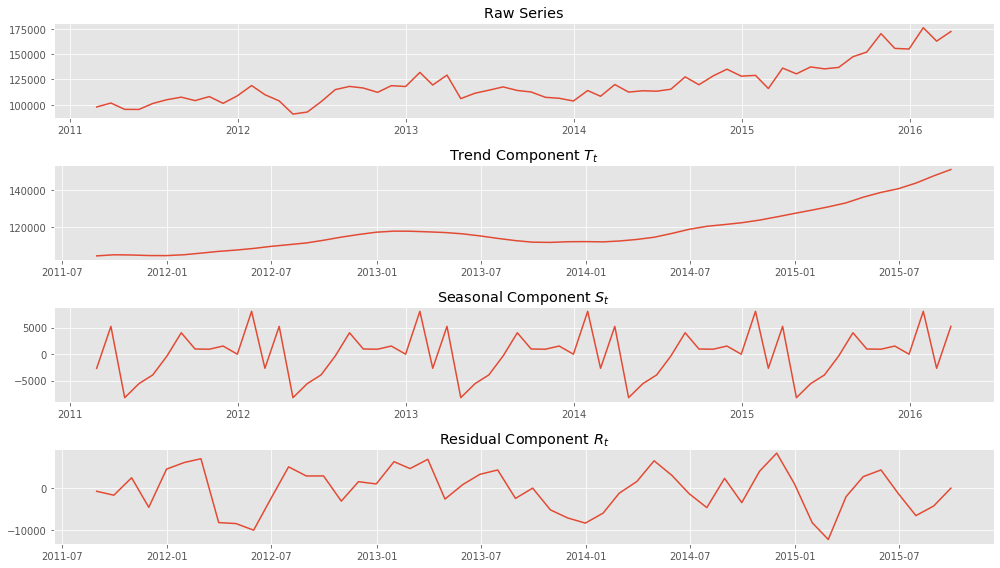

In [167]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_food2, 'M'))
plt.tight_layout()

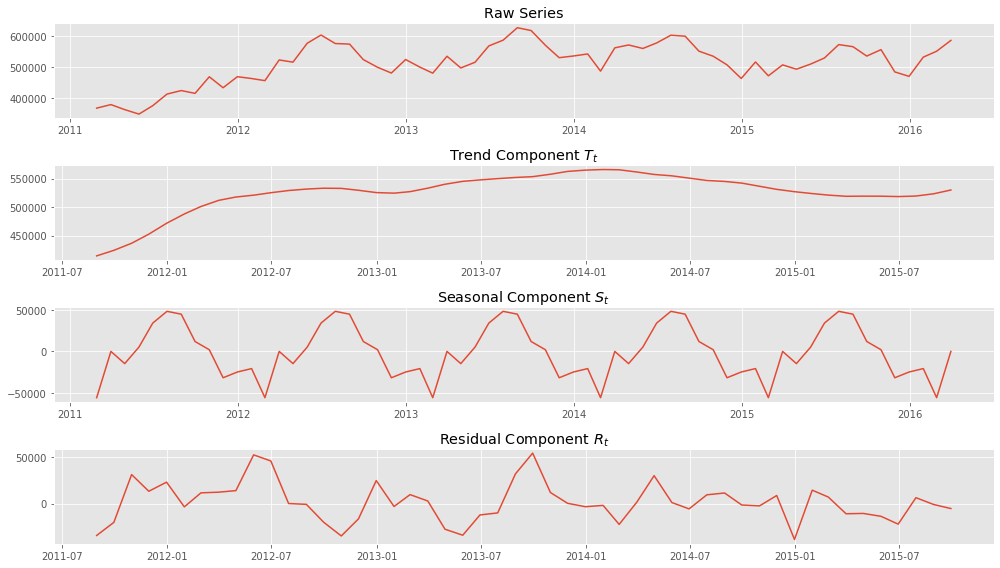

In [168]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_food3, 'M'))
plt.tight_layout()

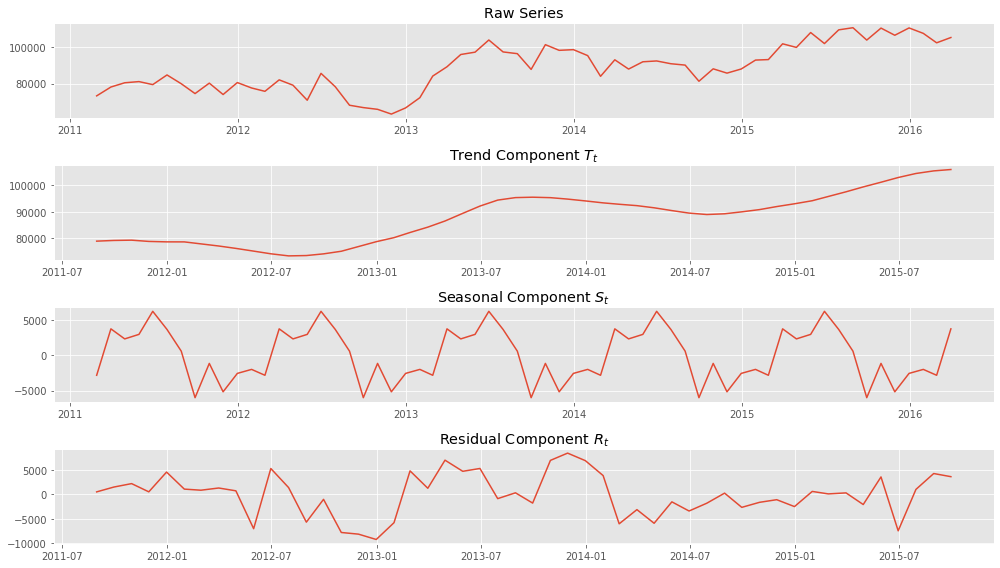

In [169]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_hobby1, 'M'))
plt.tight_layout()

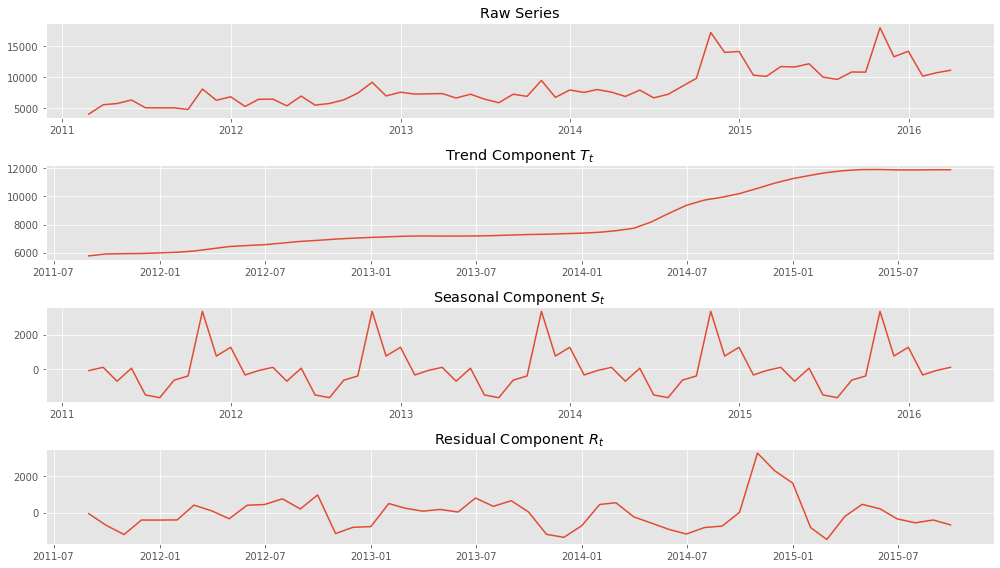

In [170]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_hobby2, 'M'))
plt.tight_layout()

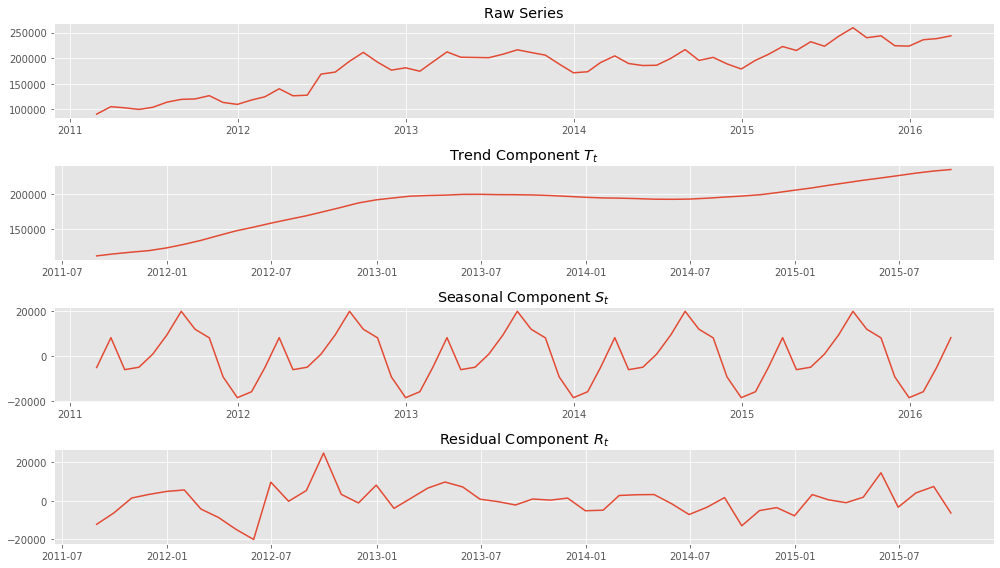

In [171]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_household1, 'M'))
plt.tight_layout()

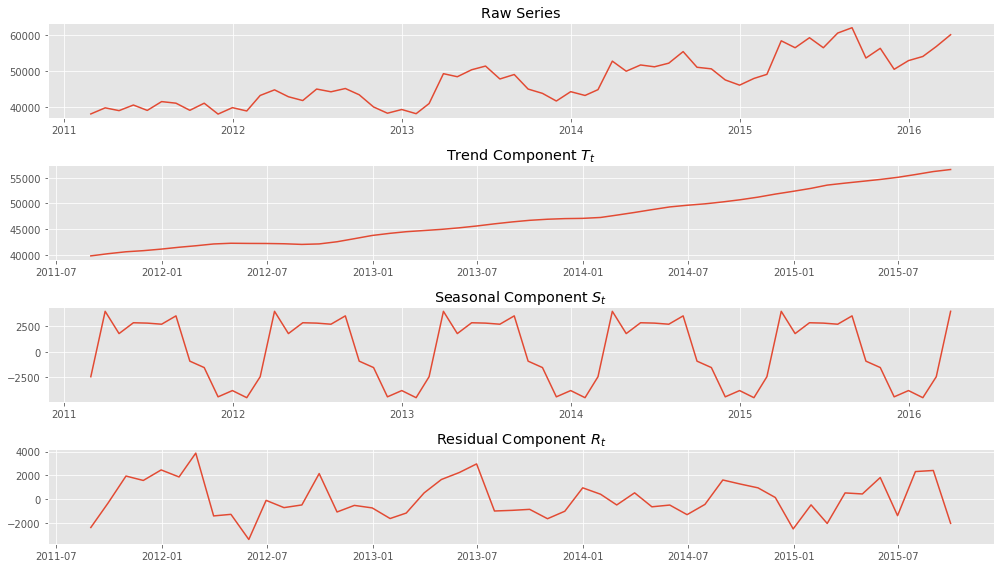

In [172]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(med_household2, 'M'))
plt.tight_layout()

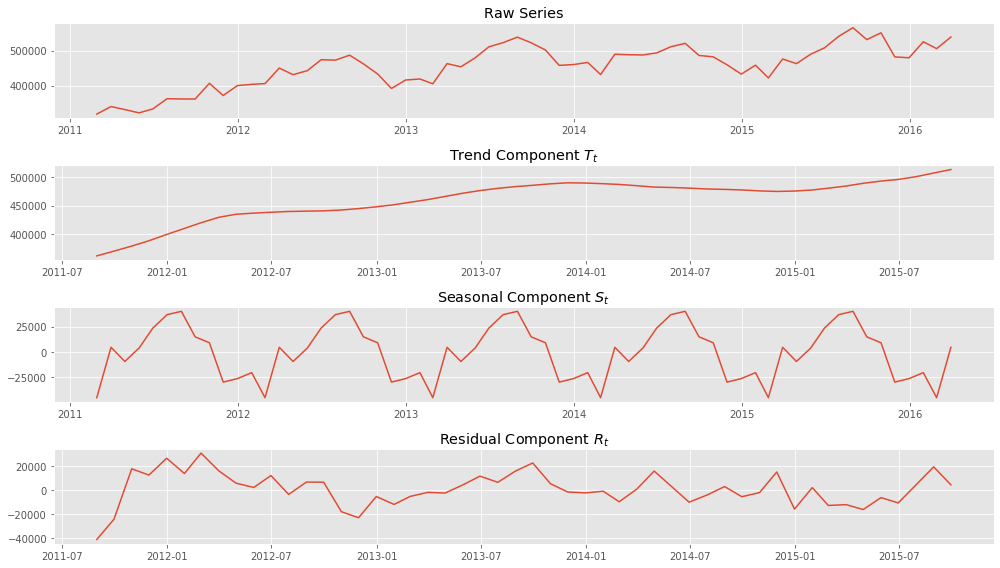

In [188]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(state_ca, 'M'))
plt.tight_layout()

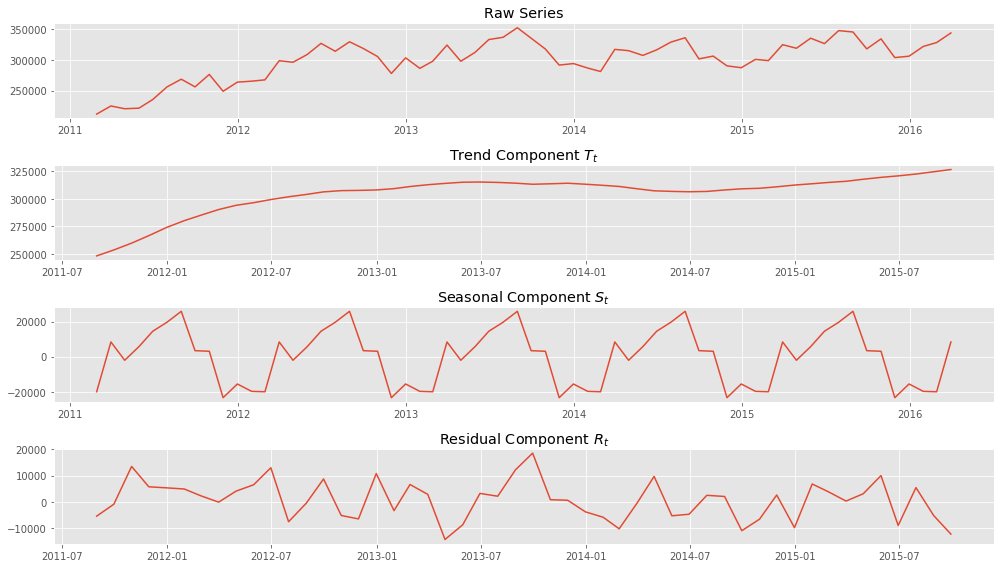

In [189]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(state_tx, 'M'))
plt.tight_layout()

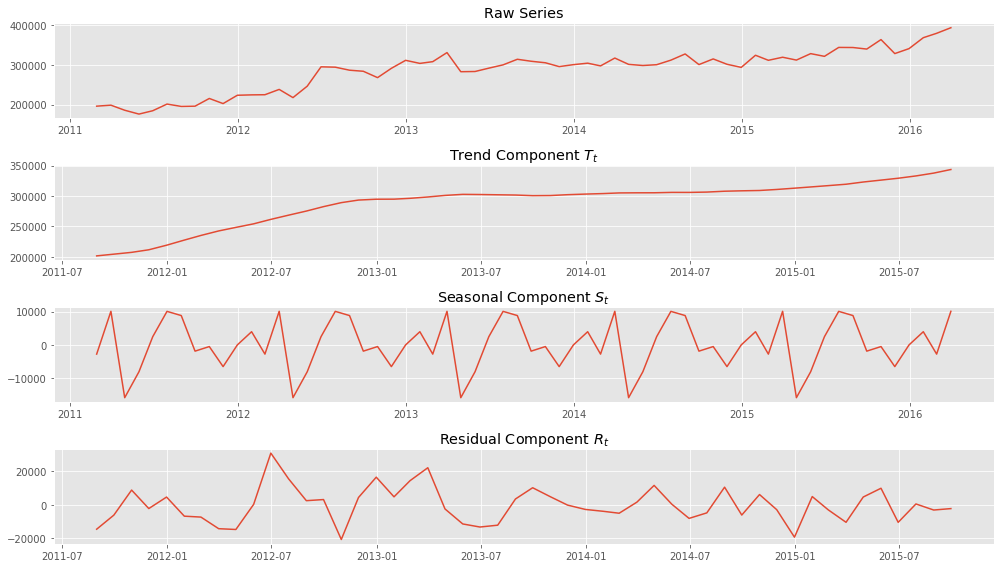

In [278]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(state_wi, 'M'))
plt.tight_layout()

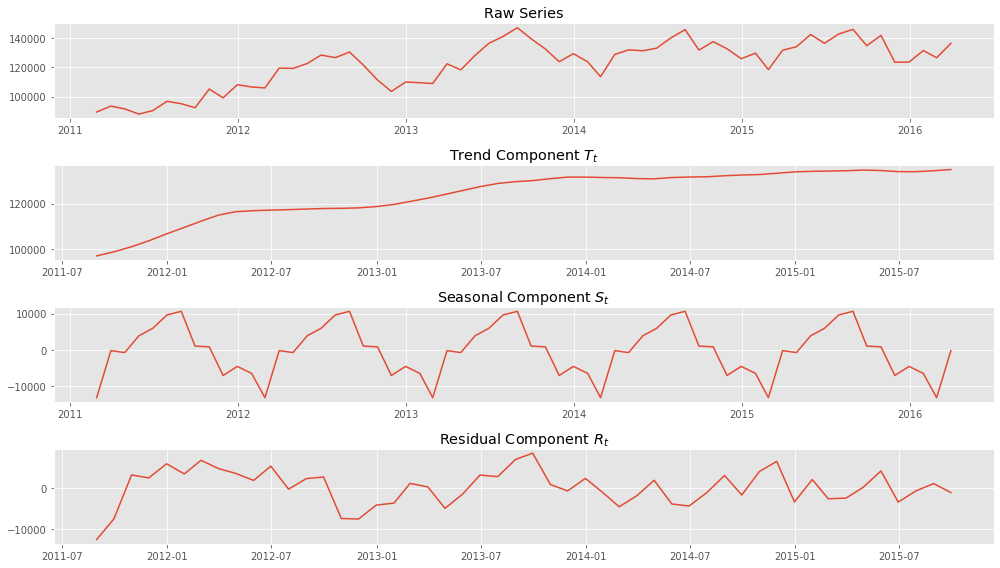

In [279]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_ca1, 'M'))
plt.tight_layout()

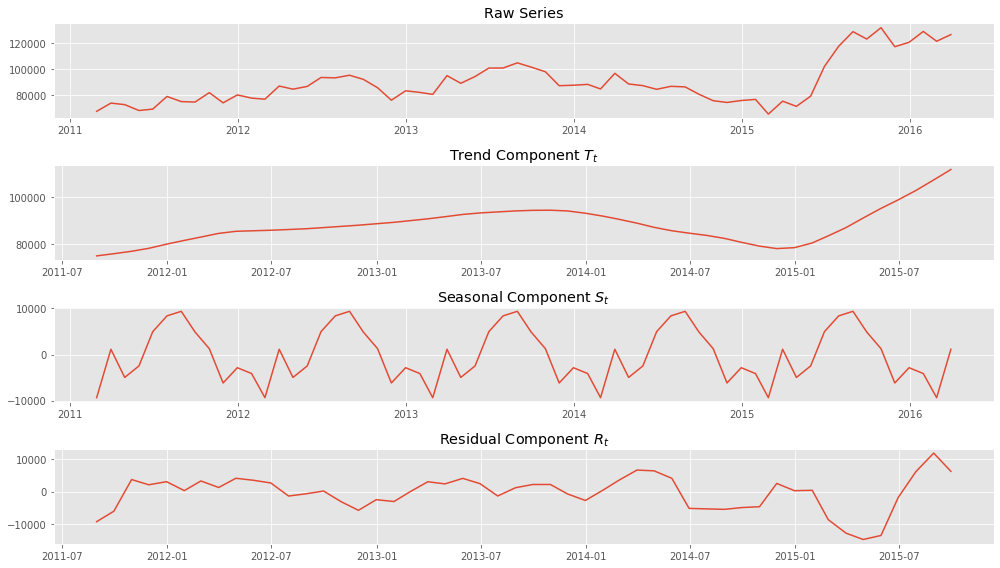

In [280]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_ca2, 'M'))
plt.tight_layout()

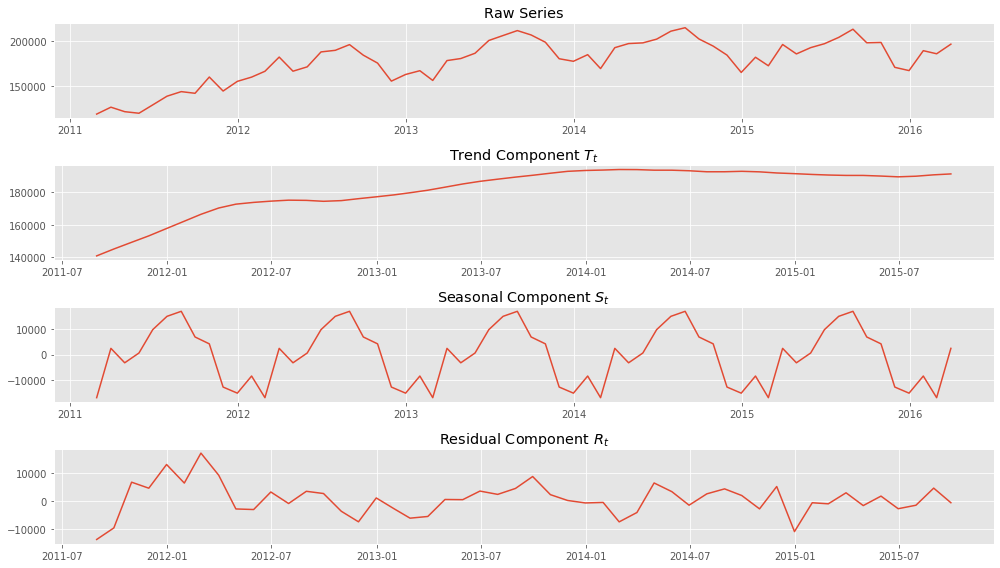

In [281]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_ca3, 'M'))
plt.tight_layout()

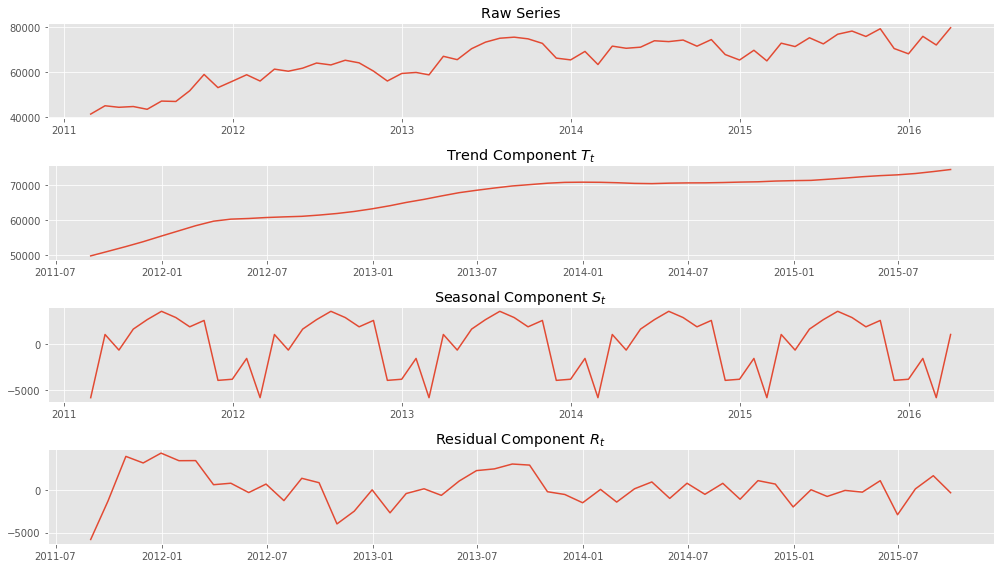

In [282]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_ca4, 'M'))
plt.tight_layout()

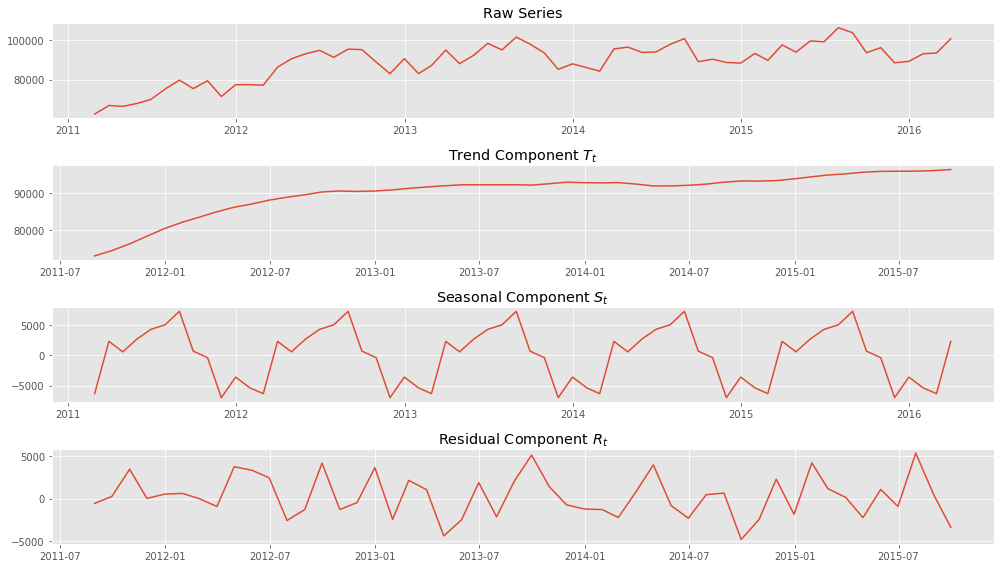

In [283]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_tx1, 'M'))
plt.tight_layout()

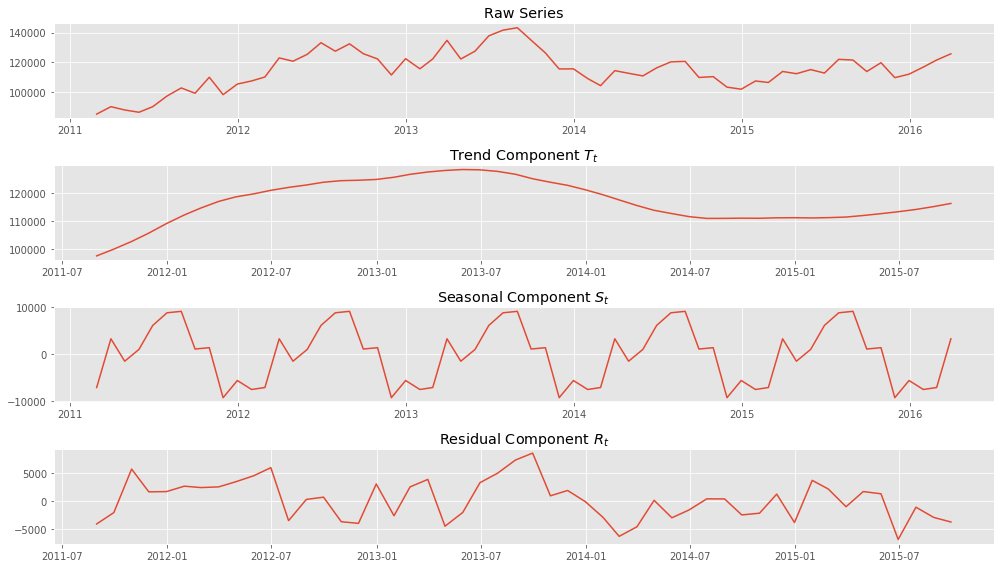

In [284]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_tx2, 'M'))
plt.tight_layout()

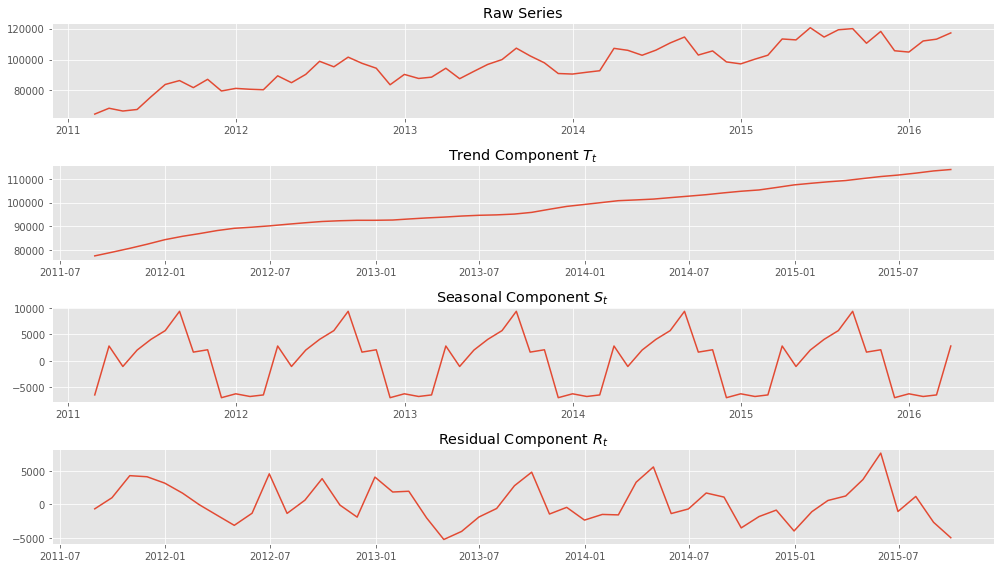

In [285]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_tx3, 'M'))
plt.tight_layout()

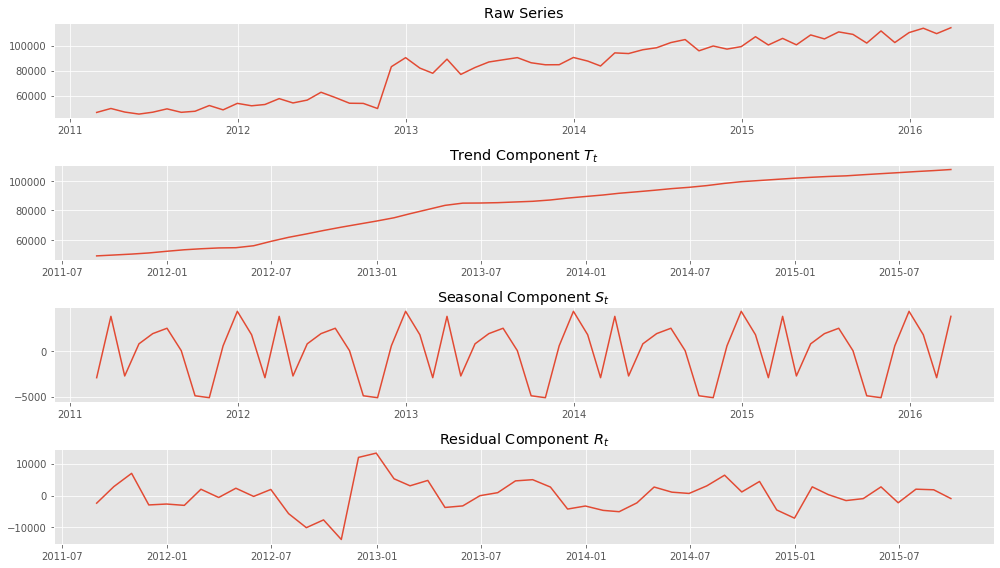

In [286]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_wi1, 'M'))
plt.tight_layout()

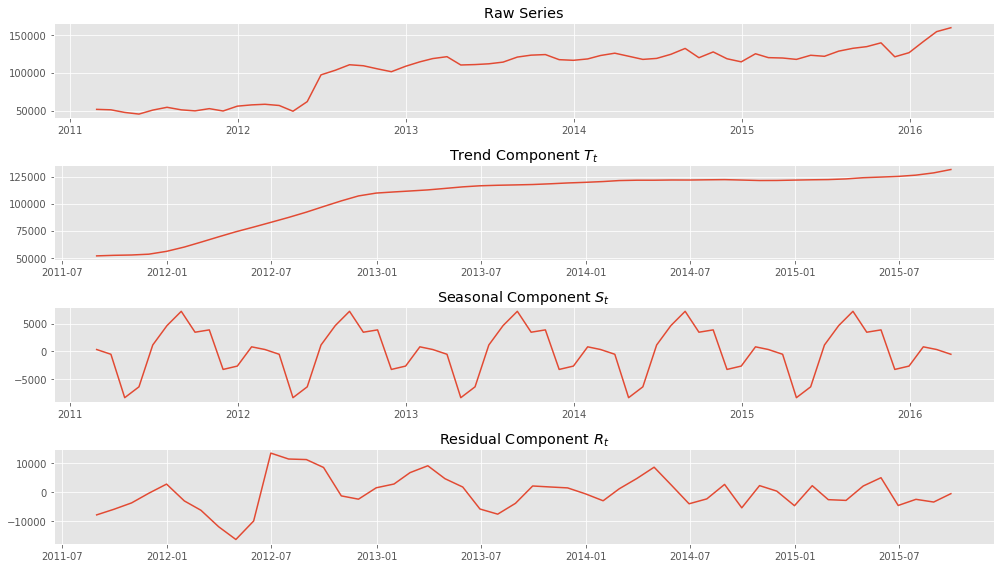

In [287]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_wi2, 'M'))
plt.tight_layout()

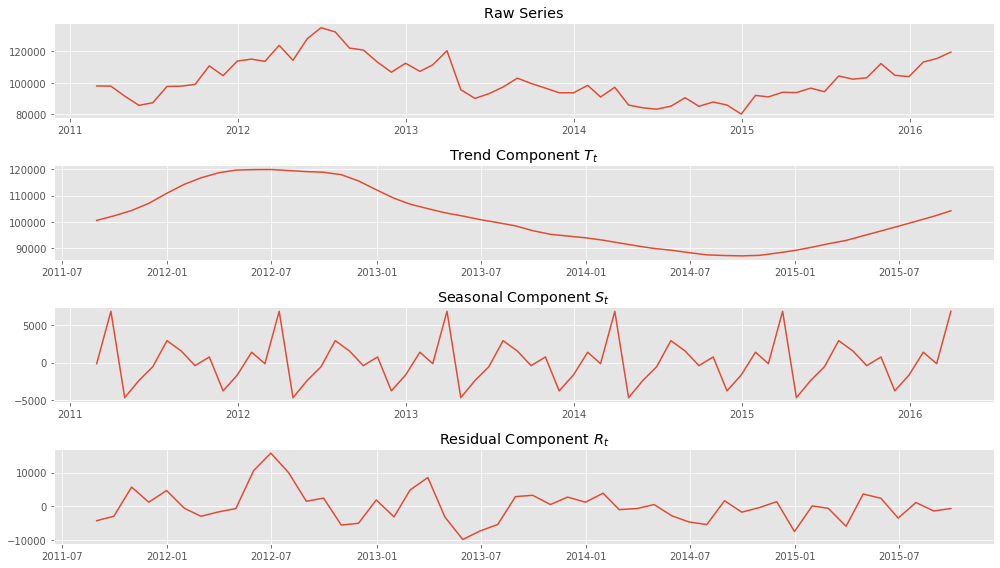

In [288]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, resample_series(store_wi3, 'M'))
plt.tight_layout()

In [176]:
#maybe make some decisions about where to cut data to get a better trend line? Start looking at forecasting?
#to forecast an individual product, perhaps forecast on the entire category, then break down by % in sub category,
#then break it down by percent in each item.
# Need to figure out how to forecast trend line into future.
#Household2 looks pretty consistent, might need to chop other ones? Hard to say.
#check for stationary to do arima?

In [245]:
def no_diff_adf_pvalue(series):
    test = sm.tsa.stattools.adfuller(series[list(series)[0]])
    return (f"ADF p-value for {list(series)[0]} series: {round(test[1], 2)}")

In [246]:
for series in series_lst:
    print(no_diff_adf_pvalue(series))

ADF p-value for TOTAL series: 0.54
ADF p-value for FOODS series: 0.38
ADF p-value for HOBBIES series: 0.31
ADF p-value for HOUSEHOLD series: 0.49
ADF p-value for FOODS_1 series: 0.06
ADF p-value for FOODS_2 series: 0.87
ADF p-value for FOODS_3 series: 0.23
ADF p-value for HOBBIES_1 series: 0.25
ADF p-value for HOBBIES_2 series: 0.01
ADF p-value for HOUSEHOLD_1 series: 0.42
ADF p-value for HOUSEHOLD_2 series: 0.62
ADF p-value for CA series: 0.43
ADF p-value for TX series: 0.1
ADF p-value for WI series: 0.7
ADF p-value for CA_1 series: 0.27
ADF p-value for CA_2 series: 0.9
ADF p-value for CA_3 series: 0.16
ADF p-value for CA_4 series: 0.42
ADF p-value for TX_1 series: 0.08
ADF p-value for TX_2 series: 0.09
ADF p-value for TX_3 series: 0.27
ADF p-value for WI_1 series: 0.65
ADF p-value for WI_2 series: 0.78
ADF p-value for WI_3 series: 0.25


In [250]:
def diff1_adf_pvalue(series):
    test = sm.tsa.stattools.adfuller(series[list(series)[0]].diff()[1:])
    return(f"ADF p-value for differenced {list(series)[0]} series: {round(test[1], 2)}")

for series in series_lst:
    print(diff1_adf_pvalue(series))

ADF p-value for differenced TOTAL series: 0.0
ADF p-value for differenced FOODS series: 0.0
ADF p-value for differenced HOBBIES series: 0.0
ADF p-value for differenced HOUSEHOLD series: 0.0
ADF p-value for differenced FOODS_1 series: 0.0
ADF p-value for differenced FOODS_2 series: 0.0
ADF p-value for differenced FOODS_3 series: 0.0
ADF p-value for differenced HOBBIES_1 series: 0.0
ADF p-value for differenced HOBBIES_2 series: 0.0
ADF p-value for differenced HOUSEHOLD_1 series: 0.0
ADF p-value for differenced HOUSEHOLD_2 series: 0.0
ADF p-value for differenced CA series: 0.0
ADF p-value for differenced TX series: 0.0
ADF p-value for differenced WI series: 0.0
ADF p-value for differenced CA_1 series: 0.0
ADF p-value for differenced CA_2 series: 0.0
ADF p-value for differenced CA_3 series: 0.0
ADF p-value for differenced CA_4 series: 0.0
ADF p-value for differenced TX_1 series: 0.0
ADF p-value for differenced TX_2 series: 0.0
ADF p-value for differenced TX_3 series: 0.0
ADF p-value for di

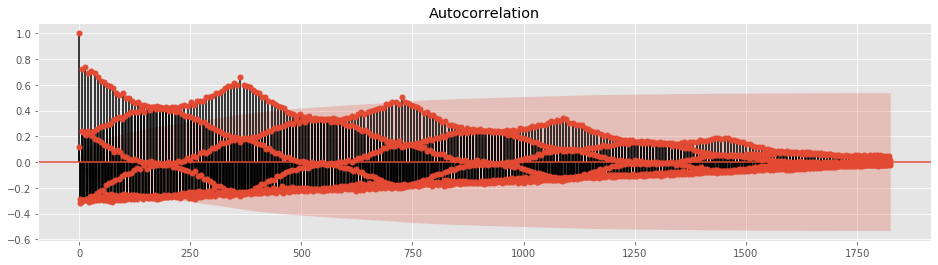

In [262]:
med_household2_diff = med_household2[list(med_household2)[0]].diff()[1:]

fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(med_household2_diff, lags=5*365, ax=ax)

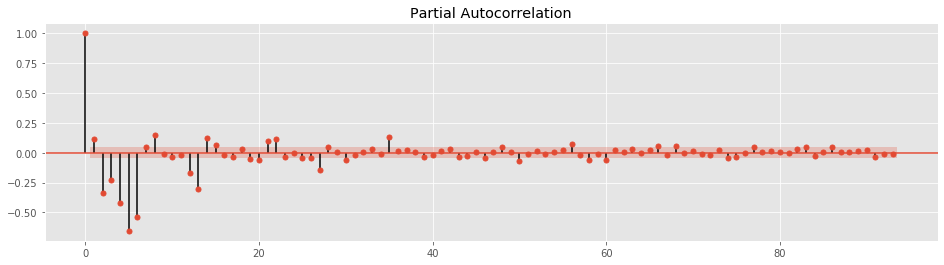

In [264]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(med_household2_diff, lags=.255*365, ax=ax, method='ywmle')

In [271]:
quarterly_med_household2 = resample_series(med_household2, 'Q')
monthly_med_household2 = resample_series(med_household2, 'M')
weekly_med_household2 = resample_series(med_household2, 'W')

In [272]:
q_med_household2_diff = quarterly_med_household2[list(quarterly_med_household2)[0]].diff()[1:]
m_med_household2_diff = monthly_med_household2[list(monthly_med_household2)[0]].diff()[1:]
w_med_household2_diff = weekly_med_household2[list(weekly_med_household2)[0]].diff()[1:]

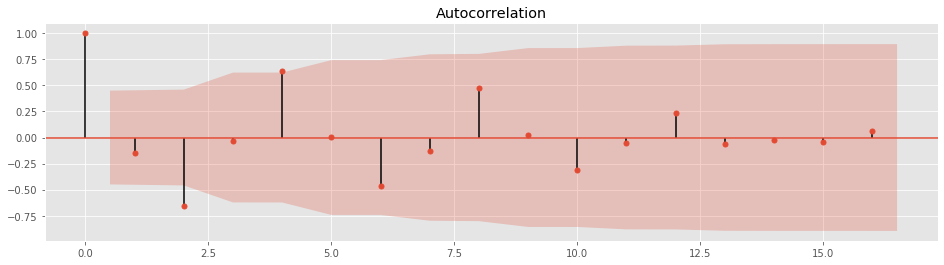

In [269]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(q_med_household2_diff, lags=4*4, ax=ax)

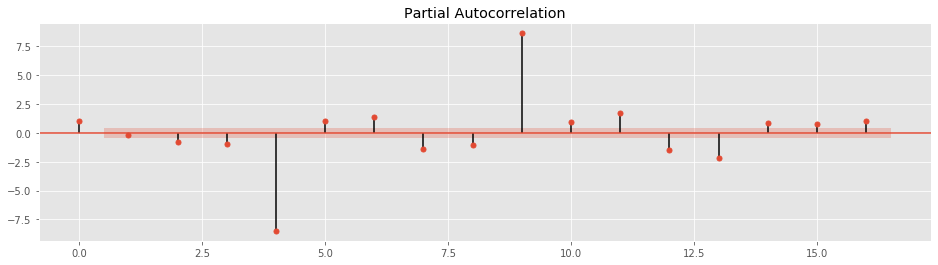

In [270]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(q_med_household2_diff, lags=4*4, ax=ax)

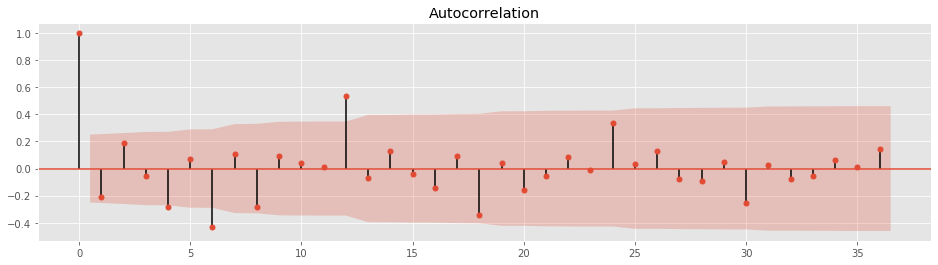

In [273]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(m_med_household2_diff, lags=12*3, ax=ax)

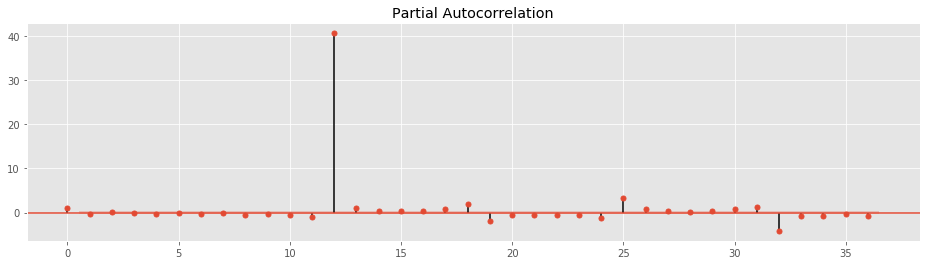

In [274]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(m_med_household2_diff, lags=12*3, ax=ax)

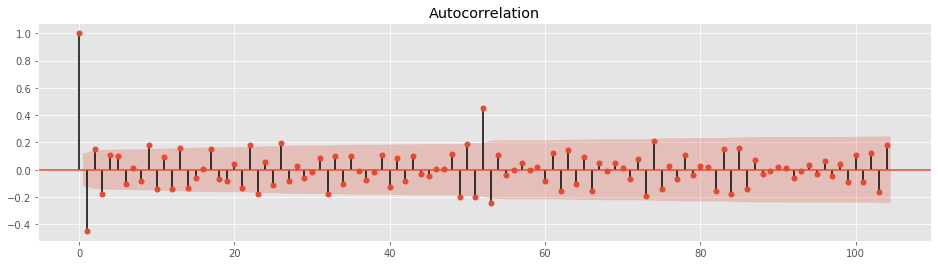

In [275]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(w_med_household2_diff, lags=52*2, ax=ax)

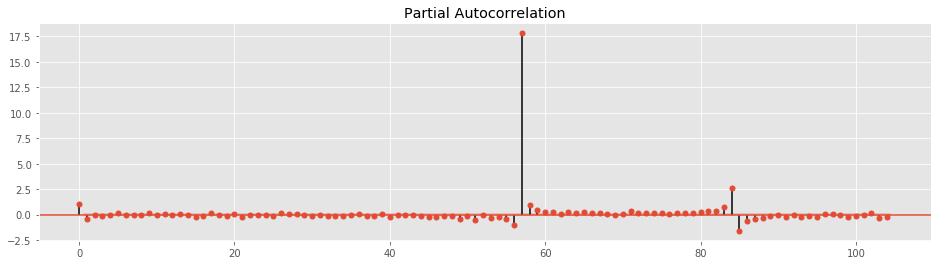

In [276]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(w_med_household2_diff, lags=52*2, ax=ax)